In [1]:
%matplotlib notebook

In [2]:
from lib import filedb
import pandas as pd
import os.path
import numpy as np
from lib import strainmap
#from figures.figure_63x_sigb_histo import subfig_indivfile_histo
from lib.analysis.sigb_histograms import make_indivfile_histogram
import scipy.io
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker


In [3]:
from lib.figure_util import strain_color
from lib import figure_util

In [4]:
basedir = "../../datasets/LSM700_63x_sigb"

cell_df = pd.read_hdf(os.path.join(basedir, "single_cell_data.h5"), "cells")
file_df = filedb.get_filedb(os.path.join(basedir, "file_list.tsv"))

In [5]:
strain_map, des_strain_map = strainmap.load()

In [6]:
for c in cell_df.columns:
    print(c)

area
distance
eccentricity
global_file_id
green_raw_bg_autofluor_bleedthrough_maxnorm
green_raw_bg_autofluor_bleedthrough_mean
green_raw_bg_autofluor_bleedthrough_meannorm
green_raw_bg_autofluor_bleedthrough_std
green_raw_bg_autofluor_maxnorm
green_raw_bg_autofluor_mean
green_raw_bg_autofluor_meannorm
green_raw_bg_autofluor_std
green_raw_bg_maxnorm
green_raw_bg_mean
green_raw_bg_meannorm
green_raw_bg_std
green_raw_maxnorm
green_raw_mean
green_raw_meannorm
green_raw_std
image_col
image_row
length
perimeter
red_raw_bg_autofluor_maxnorm
red_raw_bg_autofluor_mean
red_raw_bg_autofluor_meannorm
red_raw_bg_autofluor_std
red_raw_bg_maxnorm
red_raw_bg_mean
red_raw_bg_meannorm
red_raw_bg_std
red_raw_maxnorm
red_raw_mean
red_raw_meannorm
red_raw_std
segment_label
slice_col
slice_row


In [35]:
def get_histogram(df, column, inbins, slice_info, dset, percentile, basedir="."):
    bins = np.linspace(*inbins)

    histo_res = make_indivfile_histogram(df,
                                         column,
                                         bins,
                                         slice_info,
                                         percentages=True,
                                         percentile=percentile,
                                         print_out_stats=True)
    names = "cbins", "indiv_hists", "mean_indiv", "histo_all", "uniques", "n", "stats"
    save = { k: v for (k, v) in zip(names, histo_res)} 
    return save

In [36]:
import scipy.stats 

In [37]:
def get_figure_std(ax, df, column, inbins, slice_info, dset, percentile, basepath, kwargs={},):

    cdata = get_histogram(df, column, inbins, slice_info, dset, percentile, basepath)
    (meanval, std, mskewval, pskewval, modeval, cvval) = cdata["stats"]#.flatten()
    cbins = cdata["cbins"].flatten()
    indiv_hists = cdata["indiv_hists"]
    histo_all = cdata["histo_all"].flatten()
    print(indiv_hists.shape)
    
    if kwargs["max_min"] == "color":
        min_stdiv = histo_all - np.std(indiv_hists, axis=0)
        max_stdiv = histo_all + np.std(indiv_hists, axis=0)
        ax.fill_between(cbins, min_stdiv, max_stdiv, color=kwargs["color"], alpha=0.3)

    elif kwargs["max_min"] == "indiv":
        for i in range(indiv_hists.shape[0]):
            ax.plot(cbins, indiv_hists[i, :], color="gray", alpha=0.3)
    else:
        pass

    line, = ax.plot(cbins, histo_all, color=kwargs["color"])
    return ax, line

In [38]:
figure_dir ="."

In [41]:
def plot_histograms(axhisto, list_of_histos, slice_info, dset ):
    time, location, strain = dset
    for i, (strain, chan, tbins, label, color) in enumerate(list_of_histos):
        print(strain)
        fids = file_df[(file_df["time"] == time) &
                        (file_df["location"] == location) &
                        (file_df["strain"] == des_strain_map[strain])].index
        strain_df = cell_df[cell_df["global_file_id"].isin(fids)]

        dset = time, location, strain
        plot_args = {"color": color, "max_min":"color","mode_mean":False}
        axhisto[i], _ = get_figure_std(axhisto[i], 
                                             strain_df,
                                             chan,
                                             tbins, 
                                             slice_info, 
                                             dset,
                                             percentile,
                                             figure_dir,
                                             plot_args)

#         axhisto[i].text(1.0, 1.0, label, 
#                         horizontalalignment='right', 
#                         verticalalignment='top',
#                         color="black", 
#                         fontsize=plt.rcParams["axes.titlesize"],
#                         transform=axhisto[i].transAxes) 
        
    for a in np.ravel(axhisto):
        a.set_ylabel("Percentage of cells")
        a.set_ylim(0, 5)
        a.set_xlim(0, gmax_val)
        #a.set_xlim(0, 5)
        a.tick_params(axis='x', which='both', direction='out')#, length=2, pad=0)
        a.tick_params(axis='y', which='both', direction='out')#, length=2, pad=0)

        
    #axhisto[0].set_xlim(0, max_val)
    return axhisto


In [26]:

#rchan = "red_raw_bg_autoflor_meannorm"
gchan = "green_raw_bg_autofluor_meannorm"

gmax_val = 10
nbins = 150
gbins = (0, gmax_val, nbins)
percentile = 0
slice_srt, slice_end = 5,7
slice_info = (slice_srt, slice_end)
time = 48
location = "center"
dset = time, location, strain
fig, ax = plt.subplots( 1,1)
fig.set_size_inches(7,7)

axhisto = [ax, ax] 


list_of_histos = [ 
        ("2xqp_sigar_sigby", gchan,  gbins, "2xQP", strain_color["JLB095"]),
        ("wt_sigar_sigby", gchan, gbins, "WT P$_{sigB}$-YFP", strain_color["JLB021"])]

axhisto = plot_histograms(axhisto, list_of_histos, (slice_srt, slice_end), dset)

axhisto[0].set_xlim(0, gmax_val)
axhisto[0].set_ylim(0, 10)


NameError: name 'strain' is not defined

In [27]:
des_strain_map

{'2xqp_sigar_sigby': 'jlb095',
 '2xqp_sspby': 'jlb117',
 'delqp_sigar_sigby': 'jlb039',
 'delqp_sspby': 'jlb127',
 'delru_sigar_sigby': 'jlb088',
 'delru_sspby': 'jlb129',
 'delsigb_sigar_sigby': 'jlb098',
 'delsigb_sspby': 'jlb118',
 'delsigbx_sspby': 'jlb119',
 'rfponly_sigar': 'jlb035',
 'wt_blank': 'jlb001',
 'wt_sigar_sigby': 'jlb021',
 'wt_sigby_spoiidc': 'jlb124',
 'wt_sigby_sspbc': 'jlb109',
 'wt_sighy_sigar': 'jlb024',
 'wt_sspby': 'jlb077'}

<IPython.core.display.Javascript object>


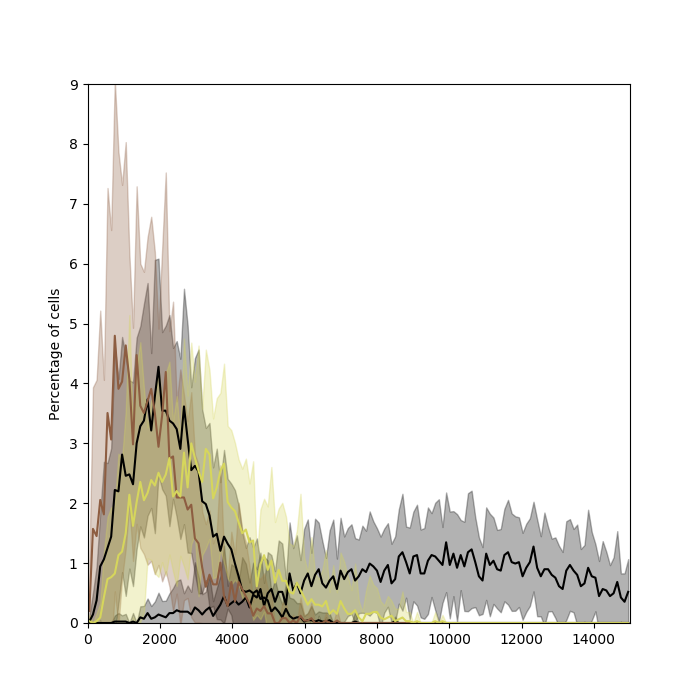

wt_sigar_sigby
mean: 10059.97
std: 3649.21
CV: 0.36
Moment skew: 0.07
Kurtosis -0.30
Number of files: 24
Cells: 4231
------------------------
(24, 149)
wt_sigar_sigby
mean: 2293.82
std: 1119.93
CV: 0.49
Moment skew: 0.65
Kurtosis 0.48
Number of files: 24
Cells: 4231
------------------------
(24, 149)
delqp_sigar_sigby
mean: 1774.01
std: 1055.88
CV: 0.60
Moment skew: 0.98
Kurtosis 1.17
Number of files: 16
Cells: 2481
------------------------
(16, 149)
delru_sigar_sigby
mean: 3143.22
std: 1569.68
CV: 0.50
Moment skew: 0.80
Kurtosis 0.71
Number of files: 18
Cells: 3268
------------------------
(18, 149)


(0, 9)

In [43]:

gchan = "green_raw_bg_mean"
rchan = "red_raw_bg_mean"
    
gmax_val = 15000#6#4

nbins = 150
gbins = (0, gmax_val, nbins)
percentile = 0
slice_srt, slice_end = 5,7#
slice_info = (slice_srt, slice_end)
time = 48
location = "center"
dset = time, location, ""

fig, ax = plt.subplots( 1,1)
fig.set_size_inches(7,7)

axhisto = [ax, ax, ax, ax]


list_of_histos = [ 
        #("2xqp_sigar_sigby", gchan,  gbins, "2xQP", strain_color["JLB095"]),
         ("wt_sigar_sigby", rchan, gbins, "WT P$_{sigB}$-YFP", strain_color["JLB021"]),

        ("wt_sigar_sigby", gchan, gbins, "WT P$_{sigB}$-YFP", strain_color["JLB021"]),
        ("delqp_sigar_sigby", gchan, gbins, "del qp", strain_color["JLB039"]),
        ("delru_sigar_sigby", gchan, gbins, "del ru", strain_color["JLB088"])


]

axhisto = plot_histograms(axhisto, list_of_histos, (slice_srt, slice_end), dset)

axhisto[0].set_xlim(0, gmax_val)
axhisto[0].set_ylim(0, 9)



<IPython.core.display.Javascript object>


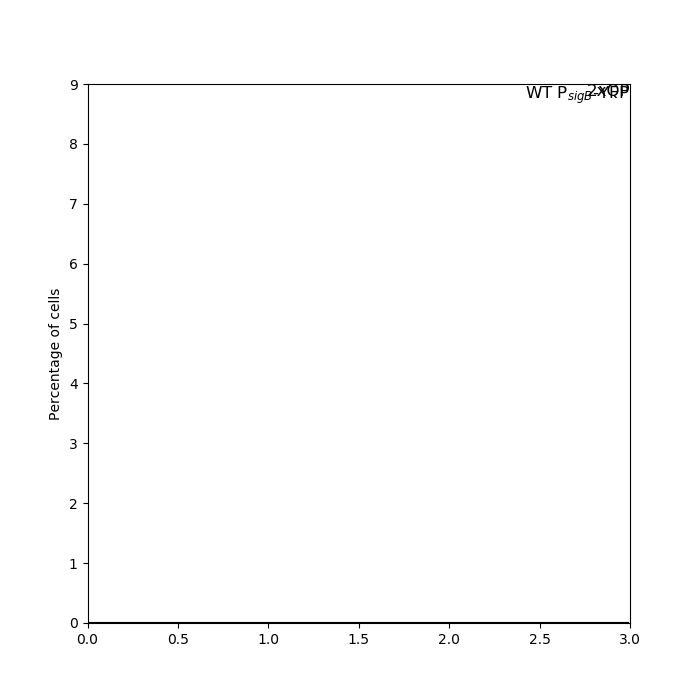

(7, 149)
(24, 149)


(0, 9)

In [29]:

gchan = "green_raw_bg_mean"
rchan = "red_raw_bg_mean"
    
gmax_val = 3

nbins = 150
gbins = (0, gmax_val, nbins)
percentile = 0
slice_srt, slice_end = 4,10#
slice_info = (slice_srt, slice_end)
time = 48
location = "center"
dset = time, location, "WT" 

fig, ax = plt.subplots( 1,1)
fig.set_size_inches(7,7)

axhisto = [ax, ax]


list_of_histos = [ 
        ("2xqp_sigar_sigby", gchan,  gbins, "2xQP", strain_color["JLB095"]),
        ("wt_sigar_sigby", gchan, gbins, "WT P$_{sigB}$-YFP", strain_color["JLB021"])]

axhisto = plot_histograms(axhisto, list_of_histos, (slice_srt, slice_end), dset)

axhisto[0].set_xlim(0, gmax_val)
axhisto[0].set_ylim(0, 9)
